# Project LatentArt: LatentArt Submission
## Level: ADVANCED

This notebook documents the implementation and experimentation for the Image Generation Submission.

### Colab Initialization
This cell automatically mounts Google Drive and installs requirements if running in Colab.

In [1]:
import os
import sys

print('🚀 Initializing Environment...\n')

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import userdata
    import shutil
    REPO_NAME = 'LatentArt'
    
    try:
        token = userdata.get('GH_TOKEN')
        username = 'urobin84'
        repo_url = f'https://{token}@github.com/{username}/{REPO_NAME}.git'
        
        os.chdir('/content')
        if os.path.exists(REPO_NAME): shutil.rmtree(REPO_NAME)
        !git clone {repo_url}
        
        repo_path = f'/content/{REPO_NAME}'
        if repo_path not in sys.path: sys.path.insert(0, repo_path)
        os.chdir(repo_path)
        !pip install -r requirements.txt
        print('\n✅ Colab Setup Complete!')
    except Exception as e:
        print(f'❌ Colab Setup Failed: {e}')
else:
    # LOCAL JUPYTER LOGIC
    # Assuming notebook is in 'notebooks/' folder
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        root_path = os.path.abspath(os.path.join(current_dir, '..'))
    else:
        root_path = current_dir
        
    if root_path not in sys.path: sys.path.insert(0, root_path)
    print(f'🏠 Running locally. Root detected: {root_path}')
    print('✅ Local environment search path updated.')

🚀 Initializing Environment...

🏠 Running locally. Root detected: /Users/muhammadmuqorrobin/Documents/Robin/LatentArt
✅ Local environment search path updated.


### Setup Environment & Utilities

In [2]:
import torch
import sys
import gc
import os
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline, StableDiffusionImg2ImgPipeline, EulerAncestralDiscreteScheduler
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

try:
    # We use 'from src.utils' because we added the project root to sys.path
    from src.utils import get_device, clear_memory
    device = get_device()
    print(f'✅ Kernel Ready. Device detected: {device}')
except ImportError as e:
    print(f'⚠️ Package import failed: {e}. Trying fallback...')
    # Try relative import if running from root directly
    try:
        from utils import get_device, clear_memory
        device = get_device()
        print(f'✅ Fallback Success! Device: {device}')
    except ImportError:
        print("❌ CRITICAL: Could not find 'src/utils.py'. Ensure you are running within the project folder.")

def load_scheduler(pipeline, scheduler_name='Euler A'):
    if scheduler_name == 'Euler A':
        pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config)
    print(f'Scheduler set to: {scheduler_name}')

negative_prompt = 'photorealistic, realistic, photograph, 3d render, messy, blurry, low quality, bad art, ugly, sketch, grainy, unfinished, chromatic aberration'

/Users/muhammadmuqorrobin/Documents/Robin/LatentArt/.venv/lib/python3.13/site-packages/diffusers/models/transformers/transformer_kandinsky.py:168: UserWarning: CUDA is not available or torch_xla is imported. Disabling autocast.
  @torch.autocast(device_type="cuda", dtype=torch.float32)
/Users/muhammadmuqorrobin/Documents/Robin/LatentArt/.venv/lib/python3.13/site-packages/diffusers/models/transformers/transformer_kandinsky.py:272: UserWarning: CUDA is not available or torch_xla is imported. Disabling autocast.
  @torch.autocast(device_type="cuda", dtype=torch.float32)


✅ Kernel Ready. Device detected: mps


### Kriteria 1: Text-to-Image (T2I)
#### Basic: Simple Generation

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /Users/muhammadmuqorrobin/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /Users/muhammadmuqorrobin/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Scheduler set to: Euler A


  0%|          | 0/30 [00:00<?, ?it/s]

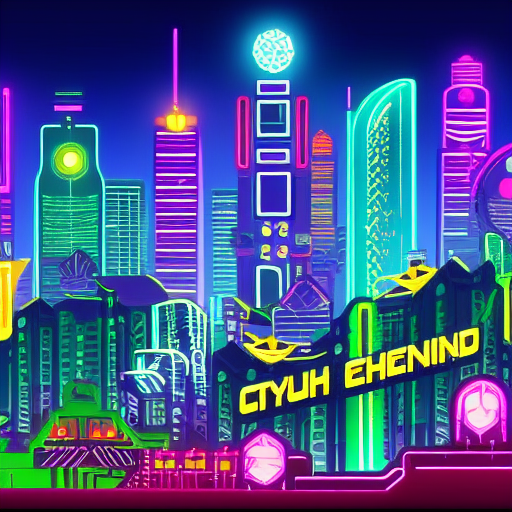

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe_t2i = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device != "cpu" else torch.float32
).to(device)

load_scheduler(pipe_t2i, "Euler A")

prompt = "A futuristic city in the style of cyberpunk, vivid neon lights, high detail"
seed = 222
generator = torch.Generator(device=device).manual_seed(seed)

image = pipe_t2i(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=generator
).images[0]

os.makedirs("../outputs", exist_ok=True)
image.save("../outputs/basic_t2i.png")
image

#### Skilled: Experimentation (Guidance Scale & Steps)

In [ ]:
# Experimentation on Guidance Scale (3-20) and Steps (10-50)
guidance_scales = [3, 7, 15, 20]
inference_steps = [10, 30, 50]
exp_prompt = "A majestic forest with magical glowing plants, digital art style"

fig, axes = plt.subplots(len(inference_steps), len(guridance_scales), figsize=(20, 15))

for i, steps in enumerate(inference_steps):
    for j, scale in enumerate(guidance_scales):
        print(f"Generating with Steps: {steps}, Scale: {scale}")
        generator = torch.Generator(device=device).manual_seed(222)
        img = pipe_t2i(
            prompt=exp_prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=steps,
            guidance_scale=scale,
            generator=generator
).images[0]
        img.save(f"../outputs/exp_steps{steps}_gs{scale}.png")
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Steps: {steps}, GS: {scale}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()
clear_memory()

#### Advanced: Two-Stage Generation (Base + Refiner)

In [ ]:
# Load Img2Img for refinement phase
pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device != "cpu" else torch.float32
).to(device)

# Stage 1: Base Generation
generator = torch.Generator(device=device).manual_seed(222)
base_image = pipe_t2i(
    prompt="A detailed portrait of a fantasy knight, cinematic lighting, intricate armor",
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=generator
).images[0]

# Stage 2: Refinement (Denoising 0.8)
refined_image = pipe_img2img(
    prompt="A detailed portrait of a fantasy knight, cinematic lighting, extreme armor detail, 4k, masterpiece",
    negative_prompt=negative_prompt,
    image=base_image.resize((768, 768)),
    strength=0.8,
    num_inference_steps=50,
    guidance_scale=8.0,
    generator=torch.Generator(device=device).manual_seed(222)
).images[0]

refined_image.save("../outputs/advanced_refined.png")
refined_image

### Kriteria 2: Inpainting & Outpainting

In [ ]:
inpaint_model_id = "runwayml/stable-diffusion-inpainting"
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    inpaint_model_id,
    torch_dtype=torch.float16 if device != "cpu" else torch.float32
).to(device)

# Manual Masking Demo
init_image = Image.new("RGB", (512, 512), (100, 100, 100)) # Grey background
mask_image = Image.new("RGB", (512, 512), (0, 0, 0)) # Black mask (do not change)
draw = ImageDraw.Draw(mask_image)
draw.rectangle([128, 128, 384, 384], fill="white") # White area = change this!

generator_inpaint = torch.Generator(device=device).manual_seed(9)

inpainted_result = pipe_inpaint(
    prompt="A majestic golden phoenix bird rising from flames",
    negative_prompt=negative_prompt,
    image=init_image,
    mask_image=mask_image,
    num_inference_steps=30,
    generator=generator_inpaint
).images[0]

inpainted_result.save("../outputs/inpainted_result.png")
plt.figure(figsize=(10,5))
plt.subplot(1,3,1); plt.imshow(init_image); plt.title("Init")
plt.subplot(1,3,2); plt.imshow(mask_image); plt.title("Mask")
plt.subplot(1,3,3); plt.imshow(inpainted_result); plt.title("Result")
plt.show()

#### Zoom-Out (Outpainting) Logic

In [ ]:
def outpaint_prepare(image, pixels=128):
    w, h = image.size
    new_w = w + pixels
    canvas = Image.new("RGB", (new_w, h), (255, 255, 255))
    canvas.paste(image, (0, 0))

    mask = Image.new("RGB", (new_w, h), (0, 0, 0))
    mask_draw = ImageDraw.Draw(mask)
    mask_draw.rectangle([w, 0, new_w, h], fill="white")

    return canvas, mask

source_img = Image.open("../outputs/basic_t2i.png").resize((512, 512))
canvas, mask = outpaint_prepare(source_img)

outpainted = pipe_inpaint(
    prompt="A futuristic neon city street extending into the distance, cybernetic details",
    negative_prompt=negative_prompt,
    image=canvas,
    mask_image=mask,
    num_inference_steps=30,
    generator=torch.Generator(device=device).manual_seed(9)
).images[0]

outpainted.save("../outputs/outpainted_result.png")
outpainted

### Kriteria 3: Streamlit Interface Logic

In [ ]:
import sys
import os
# Directly append the absolute Colab path and the exact relative path for local Jupyter
colab_path = '/content/LatentArt/src'
local_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if os.path.exists(colab_path) and colab_path not in sys.path:
    sys.path.append(colab_path)
elif os.path.exists(local_path) and local_path not in sys.path:
    sys.path.append(local_path)
print("Streamlit setup would use the following structure in a .py file:")
print("""
import streamlit as st
from streamlit_drawable_canvas import st_canvas
from diffusers import StableDiffusionPipeline

st.set_page_config(layout='wide')
tab1, tab2 = st.tabs(['Text-to-Image', 'Inpaint & Outpaint'])

with tab1:
    # Batching logic 2x2 grid
    pass

with tab2:
    # Canvas for masking logic
    pass
""")